<a href="https://colab.research.google.com/github/Emma-Cap/Deep-Learning-Project/blob/main/FORSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import zipfile
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import math
import cv2
import numpy as np

# Specifica il percorso del file zip
zip_path = '/content/archive.zip'

# Specifica la directory dove vuoi estrarre il file zip
extract_path = '/content/dataset'

# Estrai il file zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Visualizza il contenuto delle directory estratte
for root, dirs, files in os.walk(extract_path):
    print(f"In directory: {root}")
    print(f"Cartelle: {dirs}")

In directory: /content/dataset
Cartelle: ['faces_02', 'test', 'validation', 'train', 'faces']
In directory: /content/dataset/faces_02
Cartelle: ['part3']
In directory: /content/dataset/faces_02/part3
Cartelle: []
In directory: /content/dataset/test
Cartelle: []
In directory: /content/dataset/validation
Cartelle: []
In directory: /content/dataset/train
Cartelle: []
In directory: /content/dataset/faces
Cartelle: ['Train']
In directory: /content/dataset/faces/Train
Cartelle: []


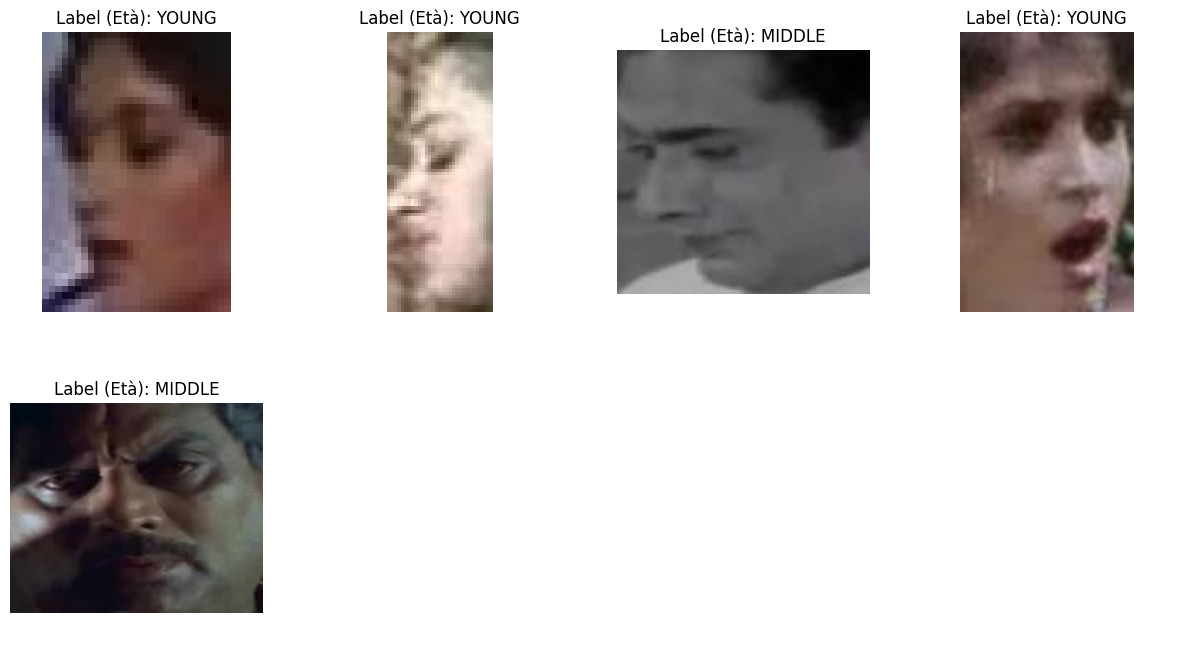

In [27]:
# Percorso del file CSV e della cartella immagini
annotations_file = '/content/dataset/faces/train.csv'
images_dir = '/content/dataset/faces/Train'

# Leggi il file CSV
annotations = pd.read_csv(annotations_file)

# Campiona casualmente 5 immagini
sample_images = annotations.sample(5)

# Configura il numero di colonne desiderato per mostrare le immagini affiancate
columns = 4

# Calcola il numero di righe necessario
rows = math.ceil(len(sample_images) / columns)

# Crea una figura e una griglia
fig, axes = plt.subplots(rows, columns, figsize=(15, rows * 4))
axes = axes.flatten()  # Rende la griglia un array monodimensionale per iterazione semplice

# Itera sulle immagini e mostrale
for idx, (ax, (_, row)) in enumerate(zip(axes, sample_images.iterrows())):
    image_path = os.path.join(images_dir, row['ID'])  # Usa la colonna 'ID' per il nome del file
    label = row['Class']  # Usa la colonna 'Class' per la label

    # Carica e mostra l'immagine
    img = Image.open(image_path)
    ax.imshow(img)
    ax.set_title(f"Label (Età): {label}")
    ax.axis('off')

# Nascondi gli assi extra se ci sono meno immagini che celle nella griglia
for ax in axes[len(sample_images):]:
    ax.axis('off')

# Mostra la figura finale
#plt.tight_layout()
#plt.show()


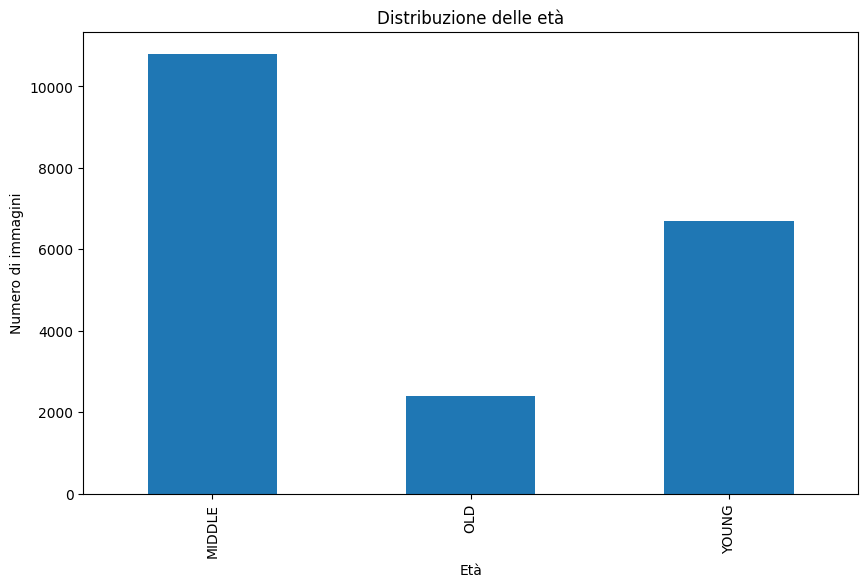

In [28]:
# Distribuzione delle età
age_distribution = annotations['Class'].value_counts().sort_index()

# Plot distribuzione
plt.figure(figsize=(10, 6))
age_distribution.plot(kind='bar')
plt.title('Distribuzione delle età')
plt.xlabel('Età')
plt.ylabel('Numero di immagini')
plt.show()

In [29]:
import os
from PIL import Image
import pandas as pd
import cv2
import torchvision.transforms as transforms
from tqdm import tqdm

# Supponiamo che queste variabili esistano già
# annotations: DataFrame con ID e Class delle immagini originali
# images_dir: Directory contenente le immagini originali
# output_dir: Directory dove salveremo tutte le immagini finali
output_dir = 'final_images'
os.makedirs(output_dir, exist_ok=True)

# **1. Filtra immagini con rumore elevato**
noise_threshold = 500
low_quality_images = []

for img_name in annotations['ID']:
    img_path = os.path.join(images_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is not None:
        laplacian = cv2.Laplacian(img, cv2.CV_64F)
        variance = laplacian.var()
        if variance > noise_threshold:
            low_quality_images.append(img_name)

# **2. Filtra immagini a bassa risoluzione**
for img_name in annotations['ID']:
    img_path = os.path.join(images_dir, img_name)
    try:
        with Image.open(img_path) as img:
            width, height = img.size
            resolution = width * height
            if resolution < 10000:  # Risoluzione bassa: 100x100
                low_quality_images.append(img_name)
    except Exception as e:
        print(f"Errore nell'aprire {img_path}: {e}")
        low_quality_images.append(img_name)

# Rimuoviamo duplicati dalla lista
low_quality_images_set = set(low_quality_images)

# Rimuovi tutte le immagini di bassa qualità dal DataFrame
filtered_annotations = annotations[~annotations['ID'].isin(low_quality_images_set)]
print(f"Immagini di bassa qualità rimosse: {len(low_quality_images_set)}")
print(f"Immagini rimanenti: {len(filtered_annotations)}")

# **3. Salva le immagini rimanenti**
for idx, row in filtered_annotations.iterrows():
    img_name = row['ID']
    img_path = os.path.join(images_dir, img_name)
    output_path = os.path.join(output_dir, img_name)
    try:
        with Image.open(img_path) as img:
            img.save(output_path)
    except Exception as e:
        print(f"Errore nel salvare {img_path}: {e}")

print(f"Immagini salvate nella directory finale: {len(filtered_annotations)}")

# **4. Salva il nuovo DataFrame con le annotazioni aggiornate**
filtered_annotations_file = os.path.join(output_dir, 'filtered_annotations.csv')
filtered_annotations.to_csv(filtered_annotations_file, index=False)
print(f"Annotazioni aggiornate salvate in: {filtered_annotations_file}")


Immagini di bassa qualità rimosse: 11692
Immagini rimanenti: 8214
Immagini salvate nella directory finale: 8214
Annotazioni aggiornate salvate in: final_images/filtered_annotations.csv


<ipython-input-31-e6596ae498ba>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-31-e6596ae498ba>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


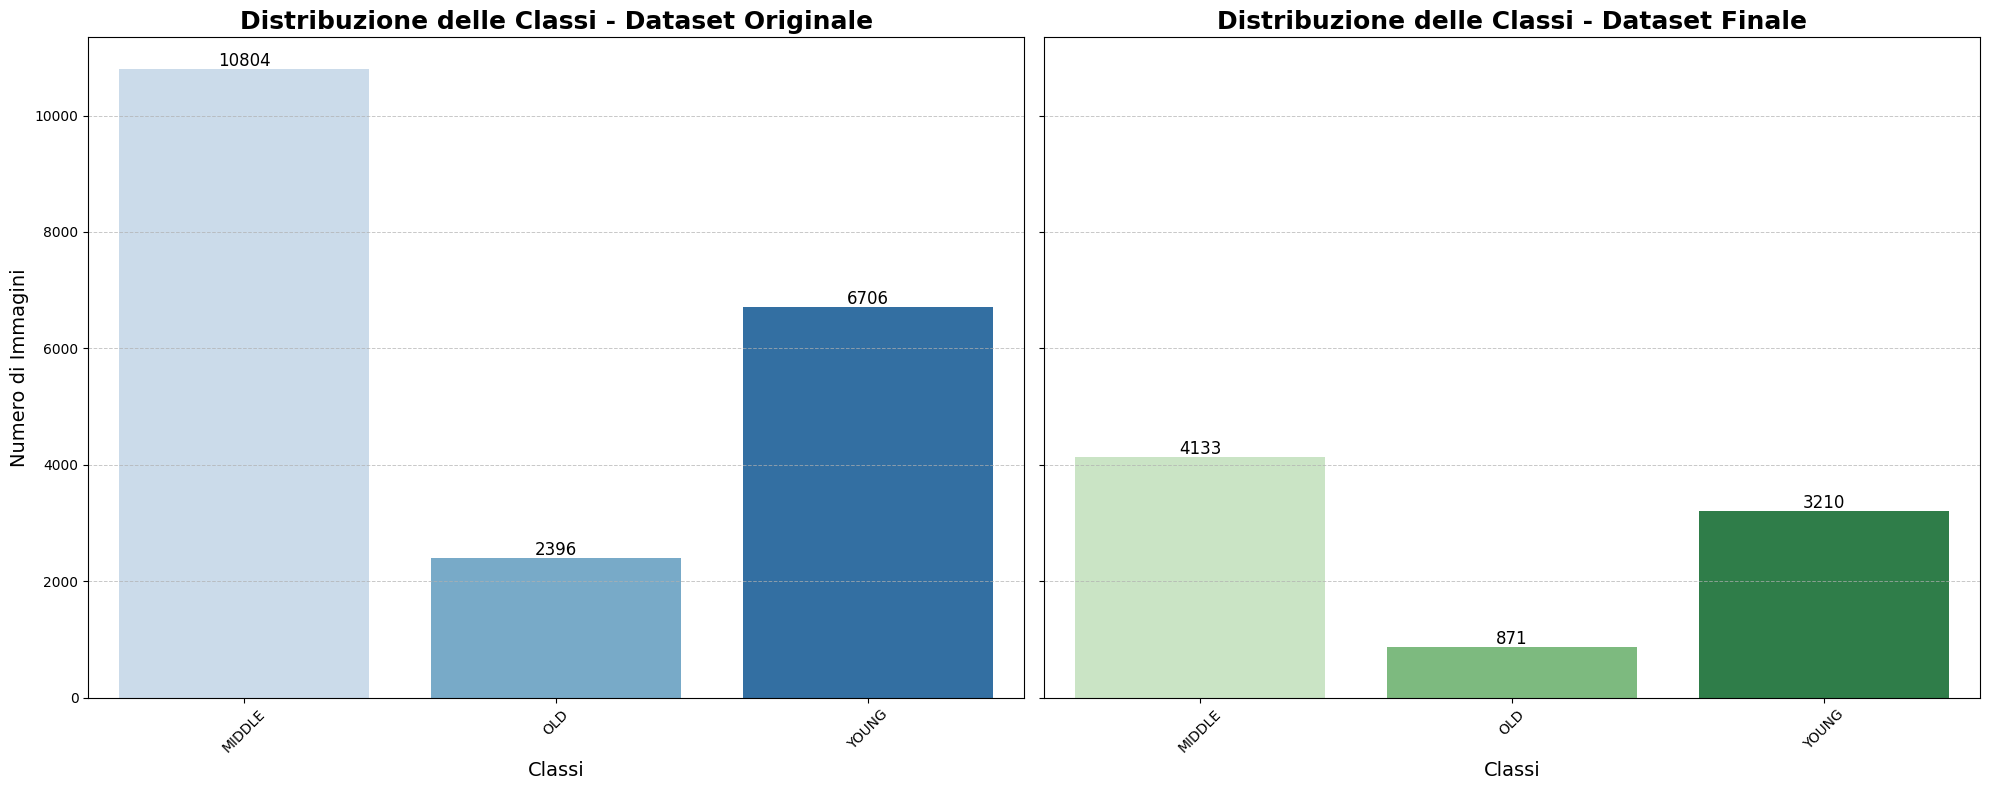

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ricarica il file delle annotazioni aggiornate
filtered_annotations_file = "final_images/filtered_annotations.csv"
filtered_annotations = pd.read_csv(filtered_annotations_file)

# Genera la distribuzione delle classi per dataset originale e finale
class_distribution_original = annotations['Class'].value_counts().sort_index()
class_distribution_final = filtered_annotations['Class'].value_counts().sort_index()

# Crea una figura con due subplot affiancati per il confronto
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Colori per i plot
palette_original = sns.color_palette("Blues", len(class_distribution_original))
palette_final = sns.color_palette("Greens", len(class_distribution_final))

# Plot per il dataset originale
sns.barplot(
    x=class_distribution_original.index,
    y=class_distribution_original.values,
    palette=palette_original,
    ax=axes[0]
)
axes[0].set_title('Distribuzione delle Classi - Dataset Originale', fontsize=18, fontweight='bold')
axes[0].set_xlabel('Classi', fontsize=14)
axes[0].set_ylabel('Numero di Immagini', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Annotazioni per mostrare i valori sulle barre
for i, value in enumerate(class_distribution_original.values):
    axes[0].text(i, value + 50, str(value), ha='center', fontsize=12, color='black')

# Plot per il dataset finale
sns.barplot(
    x=class_distribution_final.index,
    y=class_distribution_final.values,
    palette=palette_final,
    ax=axes[1]
)
axes[1].set_title('Distribuzione delle Classi - Dataset Finale', fontsize=18, fontweight='bold')
axes[1].set_xlabel('Classi', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Annotazioni per mostrare i valori sulle barre
for i, value in enumerate(class_distribution_final.values):
    axes[1].text(i, value + 50, str(value), ha='center', fontsize=12, color='black')

# Migliora il layout per evitare sovrapposizioni
plt.tight_layout()

# Mostra il grafico finale
plt.show()



In [32]:
import os
import pandas as pd
from PIL import Image
import random

# Directory e file delle annotazioni aggiornate
output_dir = "final_images"
filtered_annotations_file = os.path.join(output_dir, "filtered_annotations.csv")

# Carichiamo le annotazioni aggiornate
filtered_annotations = pd.read_csv(filtered_annotations_file)

# Calcola il numero di immagini attuali per classe
class_distribution = filtered_annotations['Class'].value_counts()
print("Distribuzione iniziale delle classi:")
print(class_distribution)

# Determina il numero di immagini della classe meno numerosa
min_class_size = class_distribution.min()

# Trova le classi con più immagini rispetto alla classe meno numerosa
classes_to_reduce = class_distribution[class_distribution > min_class_size].index.tolist()

# Rimuovi immagini casualmente solo dalle classi più numerose
images_to_remove = []
for class_name in classes_to_reduce:
    class_images = filtered_annotations[filtered_annotations['Class'] == class_name]
    num_to_remove = len(class_images) - min_class_size

    # Campioniamo casualmente le immagini da rimuovere
    images_to_remove += class_images.sample(num_to_remove, random_state=42)['ID'].tolist()

# Aggiorna le annotazioni rimuovendo le immagini selezionate
balanced_annotations = filtered_annotations[~filtered_annotations['ID'].isin(images_to_remove)]
print(f"Numero totale di immagini rimosse: {len(images_to_remove)}")
print("Distribuzione aggiornata delle classi:")
print(balanced_annotations['Class'].value_counts())

# Salva le annotazioni bilanciate
balanced_annotations_file = os.path.join(output_dir, "balanced_annotations.csv")
balanced_annotations.to_csv(balanced_annotations_file, index=False)
print(f"Annotazioni aggiornate salvate in: {balanced_annotations_file}")

# Rimuovi le immagini non necessarie dalla directory
for img_name in images_to_remove:
    img_path = os.path.join(output_dir, img_name)
    if os.path.exists(img_path):
        os.remove(img_path)

print("Immagini non necessarie rimosse.")


Distribuzione iniziale delle classi:
Class
MIDDLE    4133
YOUNG     3210
OLD        871
Name: count, dtype: int64
Numero totale di immagini rimosse: 5601
Distribuzione aggiornata delle classi:
Class
MIDDLE    871
YOUNG     871
OLD       871
Name: count, dtype: int64
Annotazioni aggiornate salvate in: final_images/balanced_annotations.csv
Immagini non necessarie rimosse.


<ipython-input-33-7a0819f45506>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-33-7a0819f45506>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


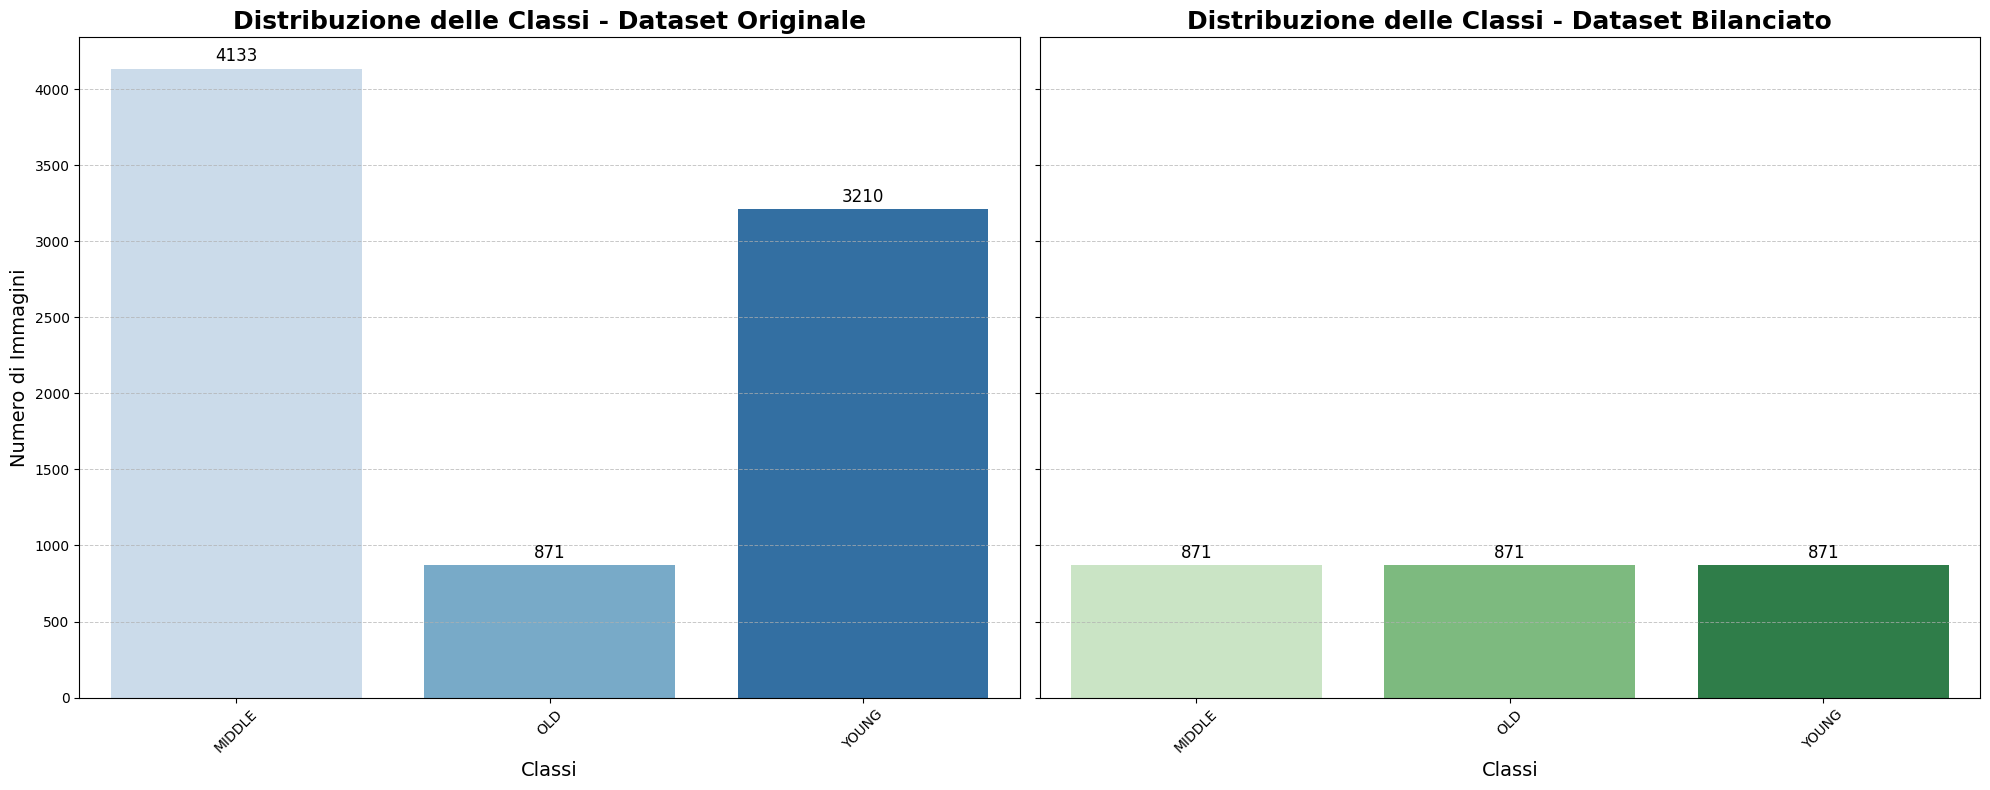

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ricarica il file delle annotazioni originali e bilanciate
filtered_annotations_file = "final_images/filtered_annotations.csv"
balanced_annotations_file = "final_images/balanced_annotations.csv"

original_annotations = pd.read_csv(filtered_annotations_file)
balanced_annotations = pd.read_csv(balanced_annotations_file)

# Genera la distribuzione delle classi per dataset originale e bilanciato
class_distribution_original = original_annotations['Class'].value_counts().sort_index()
class_distribution_balanced = balanced_annotations['Class'].value_counts().sort_index()

# Crea una figura con due subplot affiancati per il confronto
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Colori per i plot
palette_original = sns.color_palette("Blues", len(class_distribution_original))
palette_balanced = sns.color_palette("Greens", len(class_distribution_balanced))

# Plot per il dataset originale
sns.barplot(
    x=class_distribution_original.index,
    y=class_distribution_original.values,
    palette=palette_original,
    ax=axes[0]
)
axes[0].set_title('Distribuzione delle Classi - Dataset Originale', fontsize=18, fontweight='bold')
axes[0].set_xlabel('Classi', fontsize=14)
axes[0].set_ylabel('Numero di Immagini', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Annotazioni per mostrare i valori sulle barre
for i, value in enumerate(class_distribution_original.values):
    axes[0].text(i, value + 50, str(value), ha='center', fontsize=12, color='black')

# Plot per il dataset bilanciato
sns.barplot(
    x=class_distribution_balanced.index,
    y=class_distribution_balanced.values,
    palette=palette_balanced,
    ax=axes[1]
)
axes[1].set_title('Distribuzione delle Classi - Dataset Bilanciato', fontsize=18, fontweight='bold')
axes[1].set_xlabel('Classi', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Annotazioni per mostrare i valori sulle barre
for i, value in enumerate(class_distribution_balanced.values):
    axes[1].text(i, value + 50, str(value), ha='center', fontsize=12, color='black')

# Migliora il layout per evitare sovrapposizioni
plt.tight_layout()

# Mostra il grafico finale
plt.show()


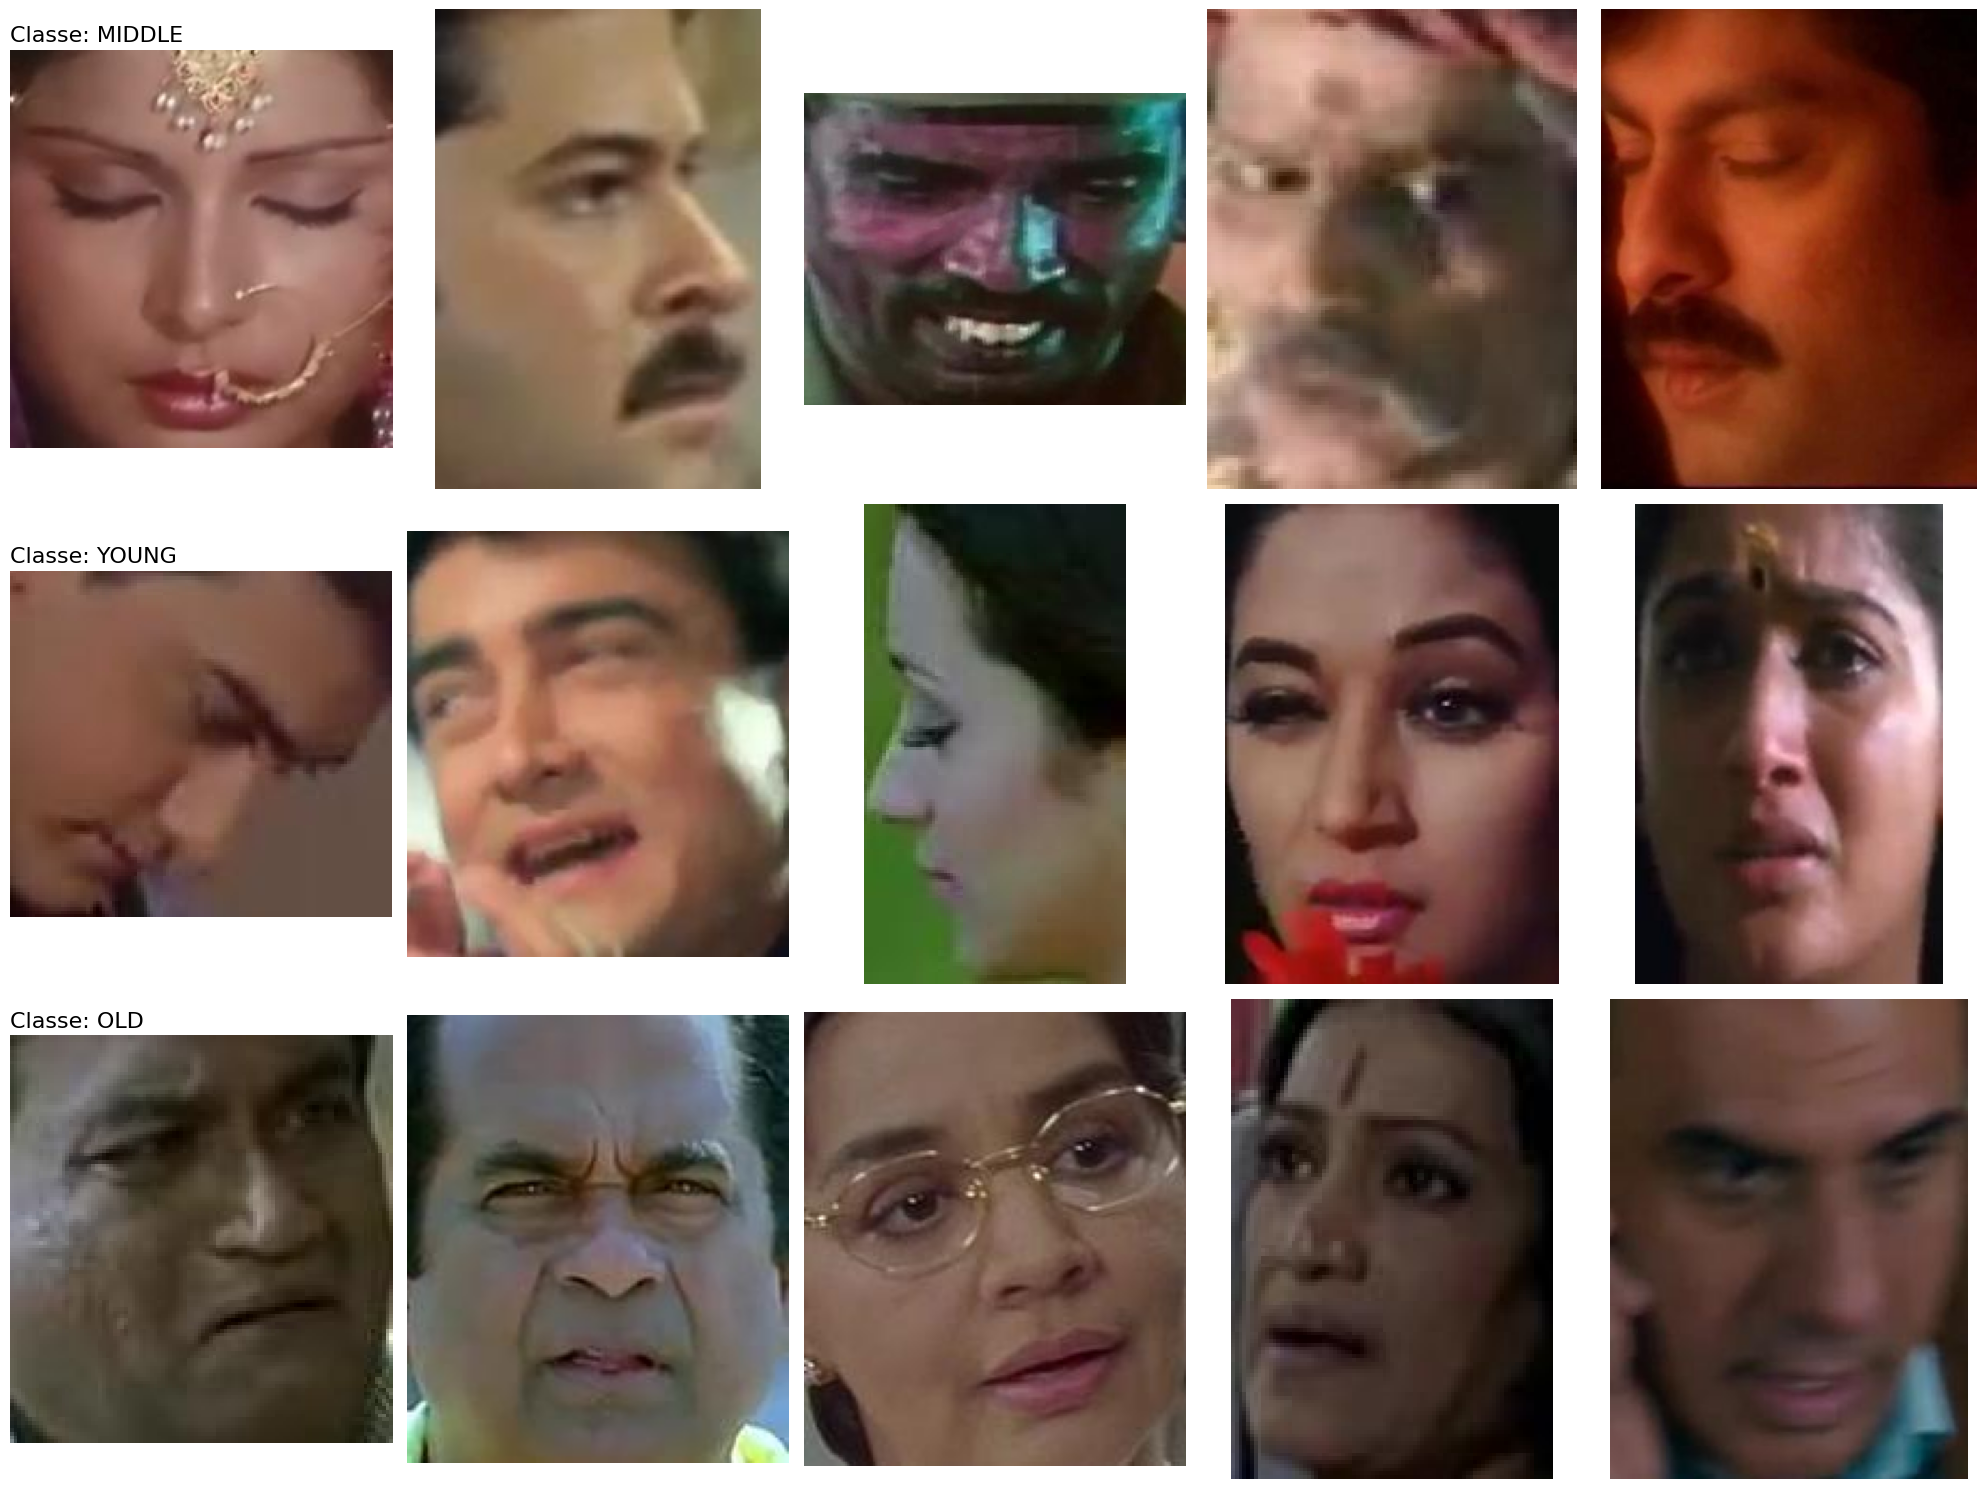

In [34]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Carica le annotazioni bilanciate
balanced_annotations_file = "final_images/balanced_annotations.csv"
balanced_annotations = pd.read_csv(balanced_annotations_file)

# Directory delle immagini finali
output_dir = "final_images"

# Numero di immagini da mostrare per classe
num_images_per_class = 5

# Ottieni le classi uniche
classes = balanced_annotations['Class'].unique()

# Crea una figura per mostrare le immagini
fig, axes = plt.subplots(len(classes), num_images_per_class, figsize=(20, 5 * len(classes)))

# Itera su ogni classe
for class_idx, class_name in enumerate(classes):
    # Filtra le annotazioni per la classe corrente
    class_images = balanced_annotations[balanced_annotations['Class'] == class_name]

    # Seleziona casualmente `num_images_per_class` immagini
    sampled_images = class_images.sample(num_images_per_class, random_state=42)['ID']

    # Mostra ogni immagine in una riga della griglia
    for image_idx, img_name in enumerate(sampled_images):
        img_path = os.path.join(output_dir, img_name)
        img = Image.open(img_path)
        ax = axes[class_idx, image_idx]
        ax.imshow(img)
        ax.axis('off')
        if image_idx == 0:  # Aggiungi il titolo della classe alla prima immagine della riga
            ax.set_title(f"Classe: {class_name}", fontsize=16, loc='left')

# Migliora il layout per evitare sovrapposizioni
plt.tight_layout()
plt.show()


In [37]:
import os
import pandas as pd

# Directory delle immagini finali
final_images_dir = "final_images"
balanced_annotations_file = os.path.join(final_images_dir, "balanced_annotations.csv")

# Carica le annotazioni bilanciate
balanced_annotations = pd.read_csv(balanced_annotations_file)

# Ottieni la lista degli ID delle immagini dal file delle annotazioni
valid_image_ids = set(balanced_annotations['ID'])

# Conta le immagini presenti nella directory
all_images = [
    file for file in os.listdir(final_images_dir)
    if os.path.isfile(os.path.join(final_images_dir, file)) and file.lower().endswith(('.jpg', '.jpeg', '.png'))
]

# Elimina le immagini che non sono nel file delle annotazioni bilanciate
images_removed = 0
for img_name in all_images:
    if img_name not in valid_image_ids:
        os.remove(os.path.join(final_images_dir, img_name))
        images_removed += 1

# Conta le immagini rimaste nella directory
remaining_images_count = len([
    file for file in os.listdir(final_images_dir)
    if os.path.isfile(os.path.join(final_images_dir, file)) and file.lower().endswith(('.jpg', '.jpeg', '.png'))
])

# Output del risultato
print(f"Numero di immagini rimosse: {images_removed}")
print(f"Numero di immagini rimaste nella directory: {remaining_images_count}")
print(f"Numero di annotazioni nel file bilanciato: {balanced_annotations.shape[0]}")

if remaining_images_count == balanced_annotations.shape[0]:
    print("✅ Tutte le immagini nella directory ora corrispondono alle annotazioni!")
else:
    print("❌ Ci sono ancora discrepanze tra le immagini e le annotazioni!")


Numero di immagini rimosse: 7660
Numero di immagini rimaste nella directory: 2613
Numero di annotazioni nel file bilanciato: 2613
✅ Tutte le immagini nella directory ora corrispondono alle annotazioni!


DIVIDIAMO IN TRAINING VALIDATION E TEST

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import shutil

# Percorso del file delle annotazioni bilanciate
balanced_annotations_file = 'final_images/balanced_annotations.csv'

# Directory delle immagini finali
final_images_dir = 'final_images'

# Carica il file delle annotazioni bilanciate
balanced_annotations = pd.read_csv(balanced_annotations_file)

# **1. Dividi il dataset in train (70%), temp (30%)**
train_df, temp_df = train_test_split(
    balanced_annotations,
    test_size=0.3,  # 30% per validation + test
    stratify=balanced_annotations['Class'],  # Stratifica per classe
    random_state=42
)

# **2. Dividi il temp (30%) in validation (20%) e test (10%)**
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.33,  # 33% di temp -> 10% del totale
    stratify=temp_df['Class'],  # Stratifica per classe
    random_state=42
)

# Stampa la distribuzione delle classi
print("Distribuzione delle classi nei set:")
print("Training set:\n", train_df['Class'].value_counts())
print("Validation set:\n", val_df['Class'].value_counts())
print("Test set:\n", test_df['Class'].value_counts())

# **3. Crea directory per training, validation e test**
output_dirs = {
    'train': 'dataset/train',
    'validation': 'dataset/validation',
    'test': 'dataset/test'
}

for dir_path in output_dirs.values():
    os.makedirs(dir_path, exist_ok=True)

# **4. Sposta le immagini nei rispettivi set**
def move_images(df, target_dir):
    for _, row in df.iterrows():
        img_name = row['ID']
        src_path = os.path.join(final_images_dir, img_name)
        dest_path = os.path.join(target_dir, img_name)
        if os.path.exists(src_path):  # Controlla che il file esista
            shutil.copy(src_path, dest_path)

# Sposta le immagini
move_images(train_df, output_dirs['train'])
move_images(val_df, output_dirs['validation'])
move_images(test_df, output_dirs['test'])

# Salva i file delle annotazioni per ciascun set
train_df.to_csv(os.path.join(output_dirs['train'], 'annotations_train.csv'), index=False)
val_df.to_csv(os.path.join(output_dirs['validation'], 'annotations_validation.csv'), index=False)
test_df.to_csv(os.path.join(output_dirs['test'], 'annotations_test.csv'), index=False)

print("Divisione completata. I file sono stati salvati nelle directory dei rispettivi set.")


Distribuzione delle classi nei set:
Training set:
 Class
MIDDLE    610
OLD       610
YOUNG     609
Name: count, dtype: int64
Validation set:
 Class
YOUNG     175
OLD       175
MIDDLE    175
Name: count, dtype: int64
Test set:
 Class
YOUNG     87
MIDDLE    86
OLD       86
Name: count, dtype: int64
Divisione completata. I file sono stati salvati nelle directory dei rispettivi set.


NUOVO MODELLO


In [40]:
pip install transformers datasets torch


In [41]:
import os
import pandas as pd
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [13]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.label_map = {"YOUNG": 0, "MIDDLE": 1, "OLD": 2}  # Mappiamo le etichette in numeri

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = self.annotations.iloc[idx, 0]  # Prima colonna: Nome immagine
        label = self.annotations.iloc[idx, 1]  # Seconda colonna: Classe

        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")  # Carichiamo l'immagine

        if self.transform:
            image = self.transform(image)  # Applichiamo le trasformazioni

        # Convertiamo l'etichetta in numerico
        label = self.label_map[label]
        return {"pixel_values": image, "label": label}


In [14]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# Carichiamo il processore di Hugging Face
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

# Creiamo una trasformazione compatibile
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
])


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [15]:
# Directory dataset
data_dir = "dataset"
splits = ["train", "validation", "test"]

# Creazione dataset e DataLoader
train_dataset = CustomImageDataset(
    annotations_file=os.path.join(data_dir, "train", "annotations_train.csv"),
    img_dir=os.path.join(data_dir, "train"),
    transform=transform,
)

val_dataset = CustomImageDataset(
    annotations_file=os.path.join(data_dir, "validation", "annotations_validation.csv"),
    img_dir=os.path.join(data_dir, "validation"),
    transform=transform,
)

test_dataset = CustomImageDataset(
    annotations_file=os.path.join(data_dir, "test", "annotations_test.csv"),
    img_dir=os.path.join(data_dir, "test"),
    transform=transform,
)


In [16]:
model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=3  # Numero di classi: YOUNG, MIDDLE, OLD
)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,  # Modifica in base al tempo disponibile
    learning_rate=2e-5,
    load_best_model_at_end=True,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
# Definiamo il Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
)


<ipython-input-18-2b8844a306c2>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [19]:
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:


Abort: 

In [23]:
import os
import pandas as pd
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Disabilitiamo Weights & Biases (W&B)
os.environ["WANDB_MODE"] = "disabled"

# Dataset personalizzato
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.label_map = {"YOUNG": 0, "MIDDLE": 1, "OLD": 2}

    def __len__(self):
        return int(len(self.annotations) * 0.2)  # Riduciamo al 20% del dataset

    def __getitem__(self, idx):
        img_name = self.annotations.iloc[idx, 0]
        label = self.annotations.iloc[idx, 1]

        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.label_map[label]
        return {"pixel_values": image, "label": label}

# Preprocessamento
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")  # Modello corretto
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
])

# Dataset
data_dir = "dataset"
train_dataset = CustomImageDataset(
    annotations_file=os.path.join(data_dir, "train", "annotations_train.csv"),
    img_dir=os.path.join(data_dir, "train"),
    transform=transform,
)

val_dataset = CustomImageDataset(
    annotations_file=os.path.join(data_dir, "validation", "annotations_validation.csv"),
    img_dir=os.path.join(data_dir, "validation"),
    transform=transform,
)

test_dataset = CustomImageDataset(
    annotations_file=os.path.join(data_dir, "test", "annotations_test.csv"),
    img_dir=os.path.join(data_dir, "test"),
    transform=transform,
)

# Modello
model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",  # Modello corretto e pubblico
    num_labels=3,  # Specifica il numero di classi
    ignore_mismatched_sizes=True  # Ignora il mismatch tra il layer pre-addestrato e il nuovo task
)

# Parametri di addestramento ottimizzati
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    per_device_train_batch_size=32,  # Aumentiamo il batch size
    per_device_eval_batch_size=32,
    num_train_epochs=1,  # Riduciamo a una sola epoca
    learning_rate=5e-5,
    load_best_model_at_end=True,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
)

# Addestramento
trainer.train()

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-in

Epoch,Training Loss,Validation Loss
1,0.484800,0.482479


ValueError: Found input variables with inconsistent numbers of samples: [1588, 317]

              precision    recall  f1-score   support

       YOUNG       0.84      0.87      0.86       132
      MIDDLE       0.82      0.87      0.84       153
         OLD       0.94      0.50      0.65        32

    accuracy                           0.83       317
   macro avg       0.87      0.75      0.78       317
weighted avg       0.84      0.83      0.83       317



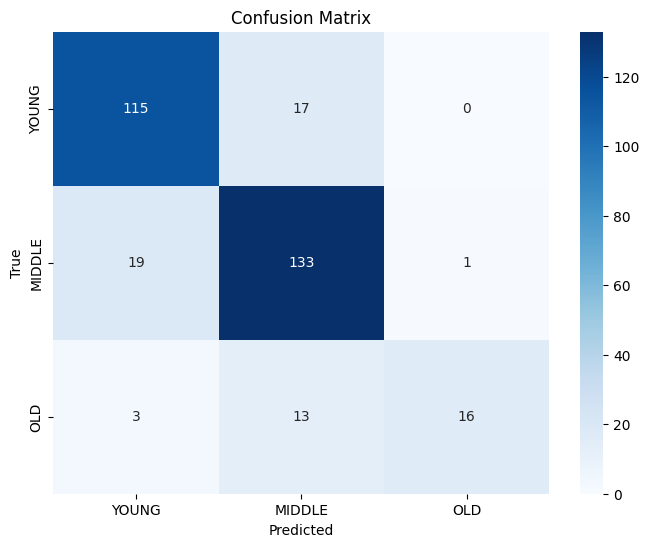

In [24]:
# Ottieni le predizioni e le etichette corrispondenti
predictions = trainer.predict(test_dataset)

# Predizioni
y_pred = predictions.predictions.argmax(axis=1)

# Etichette vere corrispondenti alle predizioni
y_true = predictions.label_ids

# Stampa il report di classificazione
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, target_names=["YOUNG", "MIDDLE", "OLD"]))

# Matrice di confusione
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d",
            xticklabels=["YOUNG", "MIDDLE", "OLD"],
            yticklabels=["YOUNG", "MIDDLE", "OLD"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [25]:
from google.colab import drive
import os

# Monta Google Drive
drive.mount('/content/drive')

# Specifica la directory di destinazione
model_save_path = "/content/drive/My Drive/trained_model"
os.makedirs(model_save_path, exist_ok=True)

# Salva il modello addestrato e il processore
model.save_pretrained(model_save_path)
image_processor.save_pretrained(model_save_path)

print(f"Modello salvato con successo in: {model_save_path}")


Mounted at /content/drive
Modello salvato con successo in: /content/drive/My Drive/trained_model
